In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

projs=['P0','Px','Py','Pz']
inserts=["tt", "tx", "ty", "tz", "xx", "xy", "xz", "yy", "yz", "zz"]
xyztdic={'x':0,'y':1,'z':2,'t':3}

ens='b'

In [2]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cB211.072.64/data_aux/cfgs_run'
with open(path,'r') as f:
    cfgs_run=f.read().splitlines()
    
path='/p/scratch/ngff/kummer3/runs/Preprocessed_files/threeps/'
cfgs_conn=[cfg2new(cfg[:7]) for cfg in os.listdir(path)]
cfgs_conn.sort()

cfgs=list(set(cfgs_run).intersection(set(cfgs_conn)))
cfgs.sort()
len(cfgs)

icfgs_run=[cfgs_run.index(cfg) for cfg in cfgs]

tfs_conn=[8,10,12,14]
tfs_disc=np.arange(3,23)

tfs=tfs_conn

In [3]:
def run():
    data={}
    path='/p/scratch/ngff/kummer3/runs/Preprocessed_files/threeps/'
    setupQ=True
    for icfg,cfg in enumerate(cfgs):
        print(f'{icfg}/{len(cfgs)}',end='              \r')
        with h5py.File(f'{path}/{cfg2old(cfg)}.h5') as f:
            for tf_key in f.keys():
                tf=int(tf_key[-2:])
                if setupQ:
                    p1s_keys=list(f[tf_key]['up'].keys()); p1s_keys.sort()
                    p1s=[[int(p1key[2:4]),int(p1key[6:8]),int(p1key[10:12])] for p1key in p1s_keys]
                    # print(p1s_keys)
                    # print(p1s)
                    
                    p1key2imom={}
                    for p1key in p1s_keys:
                        moms=[list(mom) for mom in f[tf_key]['up'][p1key]['P4_P']['OneD']['mvec'][:]]
                        imom=moms.index([0,0,0])
                        p1key2imom[p1key]=imom
                    
                    projs_key=['P4_P','P4G5G1_P','P4G5G2_P','P4G5G3_P']
                    
                    tfs=[int(tf[-2:]) for tf in f.keys()]
                    data={f'{j}_{tf}':[] for tf in tfs for j in ['j+;conn','j-;conn']}
                    
                    setupQ=False
                
                tu=np.transpose([[f[tf_key]['up'][p1key][projkey]['OneD']['threep'][:,p1key2imom[p1key]] for p1key in p1s_keys] for projkey in projs_key],[2,1,0,3,4,5])
                td=np.transpose([[f[tf_key]['dn'][p1key][projkey]['OneD']['threep'][:,p1key2imom[p1key]] for p1key in p1s_keys] for projkey in projs_key],[2,1,0,3,4,5]) 
                tp=tu+td; tm=tu-td
                
                def func(t):
                    t=t[...,0]+1j*t[...,1]
                    t=t[...,[1,2,3,4]]
                    t=(t + np.transpose(t,[0,1,2,4,3]))/2
                    t=t-np.eye(4)[None,None,None,:,:]*np.trace(t,axis1=3,axis2=4)[:,:,:,None,None]/4
                    t=np.transpose([t[:,:,:,xyztdic[insert[0]],xyztdic[insert[1]]] for insert in inserts],[1,2,3,0])
                    return t
                
                tp=func(tp); tm=func(tm)
                data[f'j+;conn_{tf}'].append(tp)
                data[f'j-;conn_{tf}'].append(tm)
                
                break
                
        break

    for key in data.keys():
        data[key]=np.array(data[key])

    # path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units.h5'
    # with h5py.File(path,'w') as f:
    #     f.create_dataset('cfgs',data=cfgs)
    #     f.create_dataset('moms',data=p1s)
    #     for key in data.keys():
    #         f.create_dataset(f'data/{key}',data=data[key])   
    
    return p1s
    
p1s=run()
print(p1s)

[[0, 1, 1], [0, 1, -1], [0, -1, 1], [0, -1, -1], [1, 0, 1], [1, 0, -1], [1, 1, 0], [1, -1, 0], [-1, 0, 1], [-1, 0, -1], [-1, 1, 0], [-1, -1, 0]]


In [ ]:
def run():
    path='/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run4/cB211.072.64/data_avgsrc/'
    data={}
    setupQ=True
    for icfg,cfg in enumerate(cfgs):
        print(f'{icfg}/{len(cfgs)}',end='              \r')
        for j in ['j+','js','jc']:
            with h5py.File(f'{path}{cfg}/discNJN_{j};g{{m,Dn}};tl.h5') as f:
                if setupQ:
                    moms=f['moms'][:]
                    dic={}
                    for i,mom in enumerate(moms):
                        dic[tuple(mom)]=i
                    inds_moms=[dic[tuple(p1+[0,0,0])] for p1 in p1s]
                    
                    data={f'{j}_{tf}':[] for tf in tfs_disc for j in ['j+;disc','js;disc','jc;disc','jg;10;disc','jg;20;disc','jg;30;disc']}
                    
                    setupQ=False
                
                for tf in tfs_disc:
                    t=f['data'][f'N_N_{j};g{{m,Dn}};tl_{tf}'][:]
                    t=t[:,inds_moms]
                    data[f'{j};disc_{tf}'].append(t)
                    
            break
        
        if True:
            with h5py.File(f'{path}{cfg}/discNJN_jg;stout.h5') as f:
                for tf in tfs_disc:
                    for stout in [10,20,30]:
                        t=f['data'][f'N_N_jg;stout{stout}_{tf}'][:]
                        t=t[:,inds_moms]
                        data[f'jg;{stout};disc_{tf}'].append(t)
            
        break
    
    t=np.array(data[f'j+;disc_3'])
    
    # path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units_disc.h5'
    # with h5py.File(path,'w') as f:
    #     f.create_dataset('cfgs',data=cfgs)
    #     f.create_dataset('moms',data=p1s)
    #     for key in data.keys():
    #         data[key]=np.array(data[key])
    #         f.create_dataset(f'data/{key}',data=data[key])   
        
# run()

In [37]:
def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=0),1,axis=0)
    return((dat[:,0]+dat[:,5]) - (dat_bw[:,10]+dat_bw[:,15]))/4

tfs=[8,10,12,14]
def run():
    data={tf:[] for tf in tfs}
    for icfg,cfg in enumerate(cfgs):
        print(f'{icfg}/{len(cfgs)}',end='              \r')
        path=f'/p/scratch/ngff/kummer3/runs/Preprocessed_files/twops/{cfg2old(cfg)}.h5'
        with h5py.File(path) as f:
            for tf_key in f.keys():
                tf=int(tf_key[-2:])
                moms=[list(mom) for mom in f[f'{tf_key}/baryons/nucl_nucl/twop_baryon_1/mvec'][:]]
                inds=[moms.index(p1) for p1 in p1s]
                t1=f[f'{tf_key}/baryons/nucl_nucl/twop_baryon_1/twop'][:]; t2=f[f'{tf_key}/baryons/nucl_nucl/twop_baryon_2/twop'][:]
                t1=np.mean(t1[:,inds],axis=1); t2=np.mean(t2[:,inds],axis=1)
                t=(t1+t2)/2
                t=t[...,0]+1j*t[...,1]
                t=symmetrize(t)
                data[tf].append(t)
        # break
    
    path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units_Ncorr.h5'
    with h5py.File(path,'w') as f:
        for tf in tfs:
            data[tf]=np.array(data[tf])
            f.create_dataset(f'{tf}',data=data[tf])

# run() 

In [38]:
indss=[]; signss=[]
for p1 in p1s:
    inds=[]; signs=[]
    for i in range(3):
        if p1[i]!=0:
            insert=['tx','ty','tz'][i]
            inds.append(inserts.index(insert))
            signs.append(p1[i])
    indss.append(inds); signss.append(signs)

def symmetrize(dat):
    t=np.mean([dat[:,:,i,0,indss[i][j]]*signss[i][j] for i in range(12) for j in [0,1]],axis=0)
    return t

# path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units_disc.h5'
# with h5py.File(path) as f:
    
#     t=f['data']['j+;disc_3']
#     t=symmetrize(t)
#     print(t[0])

# path='/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run4/cB211.072.64/data_avgmore/a0656/discNJN_j+;g{m,Dn};tl.h5'
# with h5py.File(path) as f:
#     moms=[list(mom) for mom in f['moms'][:]]
#     imom=moms.index([0,1,1,0,0,0])
#     print(f['data']['N_N_j+;g{m,Dn};tl_3'][:,imom,0,inserts.index('tz')])

In [119]:
data={}
path='/p/project1/ngff/li47/code/scratch/run/02_discNJN_1D_run3/cB211.072.64/data_merge/data.h5'
with h5py.File(path) as f:
    # print(f['N.h5']['data']['N_N'])
    moms=[list(mom) for mom in f['N.h5']['moms'][:]]
    imom=moms.index([0,1,1])
    
    t=f['N.h5']['data']['N_N'][icfgs_run,:,imom]
    data['N']=yu.jackknife(np.real(t))
    
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units_Ncorr.h5'
with h5py.File(path) as f:
    for tf in f.keys():
        t=f[tf][:]
        data[f'N_{tf}']=yu.jackknife(t)
        
    
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units_disc.h5'
with h5py.File(path) as f:
    for j in ['j+;disc','js;disc','jc;disc','jg;10;disc','jg;20;disc','jg;30;disc']:
        c3pt={}
        for tf in tfs_disc:
            t=f['data'][f'{j}_{tf}'][:]
            t=symmetrize(t)
            c3pt[tf]=yu.jackknife(t)
        data[j]=c3pt.copy()
path='/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_conn/B64_2units_conn.h5'
with h5py.File(path) as f:
    for j in ['j+;conn','j-;conn'][:1]:
        c3pt={}
        for tf in tfs_conn:
            t=f['data'][f'{j}_{tf}'][:]
            t=symmetrize(t)
            # t=(t[:,:,0,0,inserts.index('tz')]+t[:,:,0,0,inserts.index('ty')])/2
            # t=t[:,:,0,0,inserts.index('tt')]
            c3pt[tf]=yu.jackknife(t)
        data[j]=c3pt.copy()

In [120]:
ens2Njk={'b':len(cfgs)}
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs_me=pickle.load(f)
ens2RCs={ens:{} for ens in enss}
for ens in enss:
    for key in ens2RCs_me[ens]:
        if key.endswith('err'):
            continue
        ens2RCs[ens][key]=yu.jackknife_pseudo([ens2RCs_me[ens][key]],np.array([[ens2RCs_me[ens][f'{key}_err']**2+1e-10]]),ens2Njk[ens])[:,0]
ens2RCs[ens].keys()

dict_keys(['Zqq(mu=nu)', 'Zqq(mu!=nu)', 'Zqq^s(mu=nu)', 'Zqq^s(mu!=nu)', 'Zqg(mu!=nu)', 'Zgq(mu=nu)', 'Zgq(mu!=nu)', 'Zgg^0(mu!=nu)', 'Zgg^1(mu!=nu)', 'Zgg^2(mu!=nu)', 'Zgg^3(mu!=nu)', 'Zgg^4(mu!=nu)', 'Zgg^5(mu!=nu)', 'Zgg^6(mu!=nu)', 'Zgg^7(mu!=nu)', 'Zgg^8(mu!=nu)', 'Zgg^9(mu!=nu)', 'Zgg^10(mu!=nu)', 'Zgg^11(mu!=nu)', 'Zgg^12(mu!=nu)', 'Zgg^13(mu!=nu)', 'Zgg^14(mu!=nu)', 'Zgg^15(mu!=nu)', 'Zgg^16(mu!=nu)', 'Zgg^17(mu!=nu)', 'Zgg^18(mu!=nu)', 'Zgg^19(mu!=nu)', 'Zgg^20(mu!=nu)', 'Zgg^21(mu!=nu)', 'Zgg^22(mu!=nu)', 'Zgg^23(mu!=nu)', 'Zgg^24(mu!=nu)', 'Zgg^25(mu!=nu)', 'Zgg^26(mu!=nu)', 'Zgg^27(mu!=nu)', 'Zgg^28(mu!=nu)', 'Zgg^29(mu!=nu)', 'Zgg^30(mu!=nu)', 'Zgg^31(mu!=nu)', 'Zgg^32(mu!=nu)', 'Zgg^33(mu!=nu)', 'Zgg^34(mu!=nu)', 'Zgg^35(mu!=nu)', 'Zgg^36(mu!=nu)', 'Zgg^37(mu!=nu)', 'Zgg^38(mu!=nu)', 'Zgg^39(mu!=nu)', 'Zgg^40(mu!=nu)', 'Zgg^0(mu=nu)', 'Zgg^1(mu=nu)', 'Zgg^2(mu=nu)', 'Zgg^3(mu=nu)', 'Zgg^4(mu=nu)', 'Zgg^5(mu=nu)', 'Zgg^6(mu=nu)', 'Zgg^7(mu=nu)', 'Zgg^8(mu=nu)', 'Zgg^9(mu=n

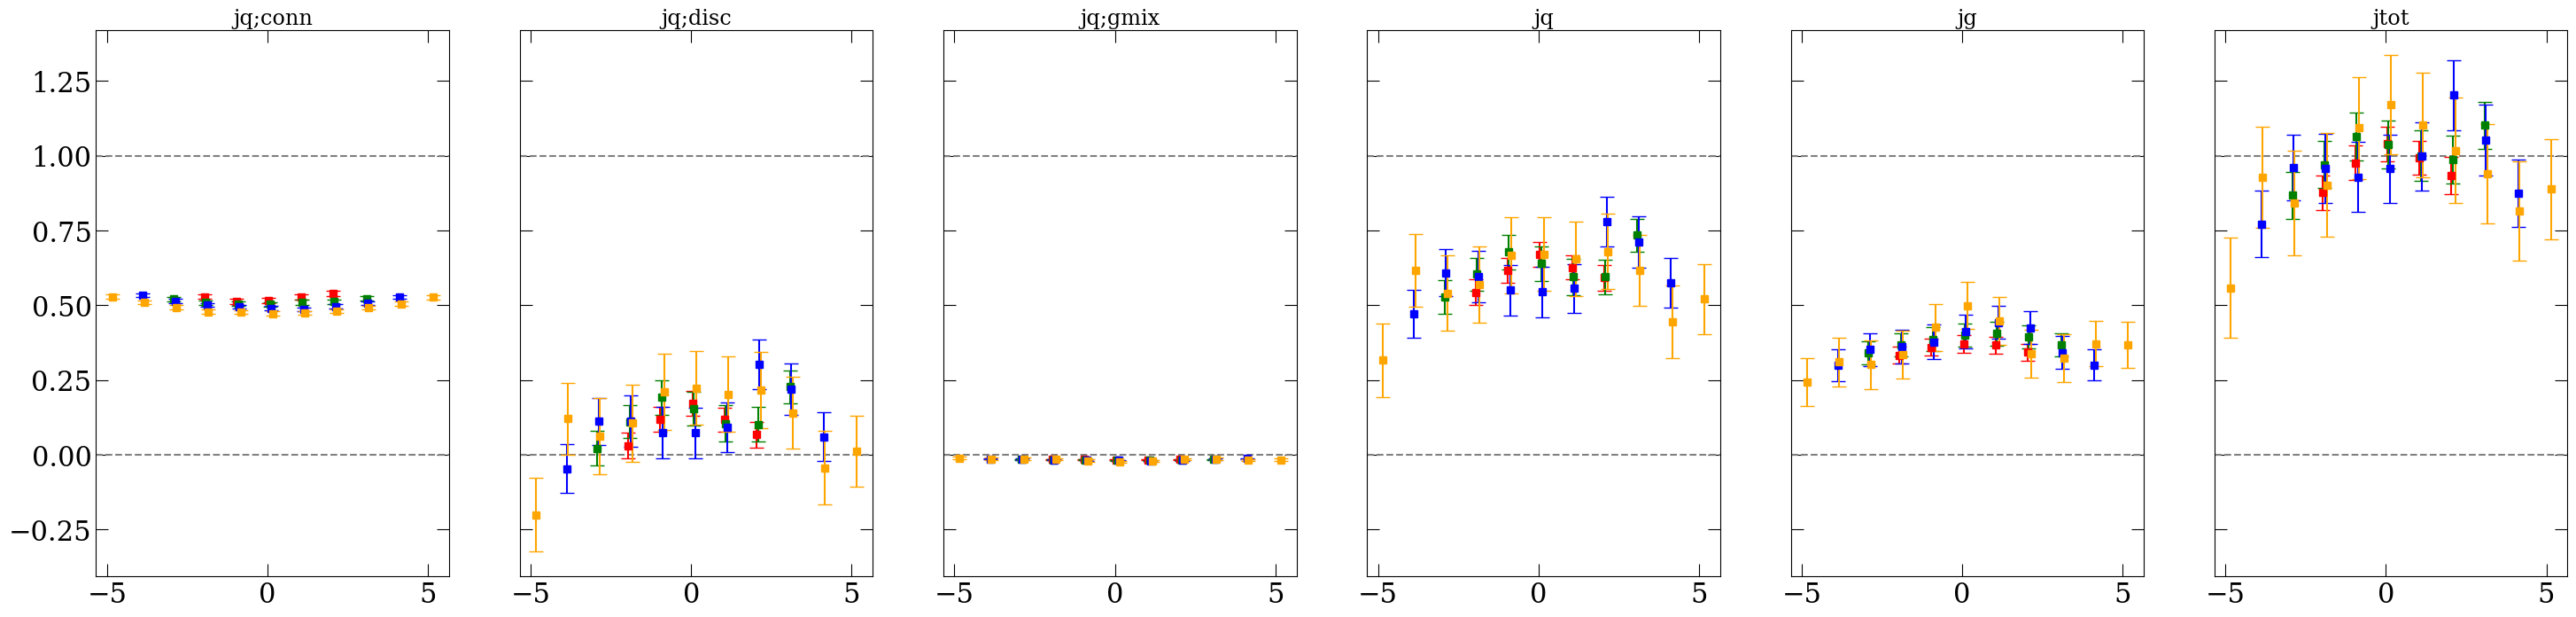

In [216]:
factor=1/(1j*2*np.pi/ens2N[ens])
amN=938/ens2aInv[ens]
aEN=np.sqrt(amN**2+(2*np.pi/ens2N[ens])**2*2)
factor_tt=1/(-3/4*aEN)

def get(tf,case,stout=10):
    tqlB_conn=data['j+;conn'][tf]/data[f'N_{tf}'][:,tf:tf+1]
    tqlB_disc=data['j+;disc'][tf]/data['N'][:,tf:tf+1]*1
    tqsB_disc=data['js;disc'][tf]/data['N'][:,tf:tf+1]*1
    tqcB_disc=data['jc;disc'][tf]/data['N'][:,tf:tf+1]*1
    tgB=data[f'jg;{stout};disc'][tf]/data['N'][:,tf:tf+1]
    
    tqB_conn=tqlB_conn
    tqB_disc=tqlB_disc+tqsB_disc+tqcB_disc
    tqB=tqB_conn+tqB_disc
    
    Zqq=ens2RCs[ens]['Zqq(mu!=nu)'][:,None]; Zqg=ens2RCs[ens]['Zqg(mu!=nu)'][:,None]*1
    Zgq=ens2RCs[ens]['Zgq(mu!=nu)'][:,None]*1; Zgg=ens2RCs[ens][f'Zgg^{stout}(mu!=nu)'][:,None]
    
    tq=Zqq*tqB + Zqg*tgB
    tg=Zgq*tqB + Zgg*tgB
    
    t={
        'jtot':tq+tg,
        'jq;conn':Zqq*tqB_conn,
        'jq;disc':Zqq*tqB_disc,
        'jq;gmix':Zqg*tgB,
        'jq':tq,
        'jg':tg,
    }[case]
    
    t=np.real(t*factor)
    return t

cases=['jq;conn','jq;disc','jq;gmix','jq','jg','jtot']

fig, axs = yu.getFigAxs(1,len(cases),Lrow=8,Lcol=6,sharex=True,sharey=True)
yu.addColHeader(axs,cases)

for icase,case in enumerate(cases):
    ax=axs[0,icase]
    # ax.set_ylim([-0.5,1.5])
    ax.axhline(0,ls='--',color='grey',marker='')
    ax.axhline(1,ls='--',color='grey',marker='')
    xunit=1; yunit=1

    colors=['r','g','b','orange']

    t_cut=2
    for i_tf,tf in enumerate(tfs_conn[:4]):
        ratio=get(tf,case,10)
        mean,err=yu.jackme(ratio)
        # print(tf,yu.un2str(mean[tf//2],err[tf//2]))
        tcs=np.arange(t_cut,tf-t_cut+1)
        plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])